# Recommendation system

## Load the data
- We don't specify category data on load because it double the df dimension
    - Load with dtype category = 4_209_304, load without using dtype category = 2_928_976 
    - Is not worthwhile cast the data to _category_ because it will give to us (either after the string normalization) to a bigger dataset

In [1]:
import pandas as pd

df_raw = pd.read_csv('../../data/03_correlation_data/presence_dataset/20210331124802/presences.csv')
df = df_raw.copy()
print(f"Dataset size:{df.memory_usage(index=True).sum()}") # dtype category = 4_209_304 | no dtype category = 2_928_976 
df_raw.head(3)

Dataset size:2928976


,thread_id,product_name
0,e9molz,110
1,e9d9z1,Ibis Ripmo AF
2,e9as86,Airstream 2


In [2]:
###
# Data cleaning
###

# String normalization
df['product_name'] = df['product_name'].str.casefold()
df['product_name'] = df['product_name'].str.strip()
print(f"Normalization product dimension: {len(df['product_name'].unique())}")

# Remove all products with all number on the name
def has_numbers(inputString):
    return all(char.isdigit() for char in inputString)
df['name_with_digits'] = df['product_name'].apply(has_numbers)
df = df[df["name_with_digits"] == False]
df = df.drop("name_with_digits", 1)
print(f"Digits cleaning product dimension: {len(df['product_name'].unique())}")

# Remove all products with more than 2 words
df = df[df['product_name'].str.split().str.len().lt(2)]
print(f"2-words product dimension: {len(df['product_name'].unique())}")

###
# Metadata calculation
###

# Extract threads and products info
threads_unique = df['thread_id'].unique()
products_unique = df['product_name'].unique()
util_mtx_dimension = (len(threads_unique), len(products_unique))

print(f"Dataset len: {len(df)}, columns:{set(df.columns)}")
print(f"Unique threads:{len(threads_unique)}")
print(f"Unique products:{len(products_unique)}")
print(f"Utility matrix - shape predicted:{util_mtx_dimension}")

if util_mtx_dimension[1] > util_mtx_dimension[0]:
    print("[INFO] There are more products than threads")

Normalization product dimension: 40168
Digits cleaning product dimension: 39727
2-words product dimension: 10691
Dataset len: 115237, columns:{'product_name', 'thread_id'}
Unique threads:27577
Unique products:10691
Utility matrix - shape predicted:(27577, 10691)


# Garrascobike _Utility Matrix_

**Step 1: matrix transformation**
- Create a matrix of dimension \[threads x products\]

**Note**
- Solution with sparse matrix from https://stackoverflow.com/a/57373497/15619275
- Other solution that give OOM:
    - ``` python
    # High memory usage here
    # [!] tricky point
    # https://stackoverflow.com/a/49035929
    df_tmp = df_presence.join(pd.get_dummies(df_presence['product_name'].apply(pd.Series).stack(), sparse=True).sum(level=0)).drop('product_name', 1)
    ```

In [3]:
import numpy as np
from scipy.sparse import csr_matrix
from bidict import bidict

# Build the indexer mapper
thread2int = bidict({u:i for i, u in enumerate(df["thread_id"].unique())})
product2int = bidict({m:i for i, m in enumerate(df["product_name"].unique())})

# Map text to index
threadsidx = [thread2int[u] for u in df["thread_id"]]
productsidx = [product2int[m] for m in df["product_name"]]

# Create matrix with 1 values [1,1,1,1,...[len(threads)]]
data = np.ones(len(threadsidx), )

# Create the utility matrix - sparse matrix [len(threads), len(products)]
utility_matrix = csr_matrix((data, (threadsidx, productsidx)))
assert utility_matrix.shape == util_mtx_dimension, f"A_sparse have a wrong dimension, expected:{util_mtx_dimension}"

print(f"Utility matrix shape:{utility_matrix.get_shape()}[threads, products]")
print("Utility matrix structure:")
utility_matrix.todense()[:3]

Utility matrix shape:(27577, 10691)[threads, products]
Utility matrix structure:


matrix([[5., 0., 0., ..., 0., 0., 0.],
        [0., 2., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.]])

-------
# Recommendation

## Matrix factorization
**Notes**:
- Approach _collaborative filtering_
    - The collaborative filtering problem can be solved using _matrix factorization_.
- ~Code and approach from [Tensorflow website](https://www.tensorflow.org/recommenders/examples/quickstart)~
- Code and approach from [pluralsight](https://www.pluralsight.com/guides/building-a-recommendation-engine-with-tensorflow)

In [4]:
import tensorflow.compat.v1 as tf

tf.disable_v2_behavior()
K = 2
R = utility_matrix

Instructions for updating:
non-resource variables are not supported in the long term


In [5]:
ratings = utility_matrix
N = util_mtx_dimension[0]
M = util_mtx_dimension[1]
P = np.random.rand(N, K)
Q = np.random.rand(M, K)
ratings = tf.placeholder(tf.float32, name="ratings")
P_matrix = tf.Variable(P, dtype=tf.float32)
Q_matrix = tf.Variable(Q, dtype=tf.float32)
P_times_Q = tf.matmul(P_matrix, Q_matrix, transpose_b=True)
squared_error = tf.square(P_times_Q - ratings)
loss = tf.reduce_sum(squared_error)

In [6]:
optimizer = tf.train.GradientDescentOptimizer(0.01)
predict = optimizer.minimize(loss)

In [7]:
# TODO: complete the TF section

--------------

# NN solution
> Solution from: https://www.analyticsvidhya.com/blog/2020/11/create-your-own-movie-movie-recommendation-system/


In [8]:
from sklearn.neighbors import NearestNeighbors
knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)

In [9]:
print(utility_matrix.shape)
knn.fit(utility_matrix)

(27577, 10691)


NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=20)

In [10]:
type(threadsidx), type(productsidx), type(thread2int), type(product2int)

(list, list, bidict.bidict, bidict.bidict)

In [11]:
product2int["stoic"]

48

In [12]:
distances, indices = knn.kneighbors(utility_matrix[119], n_neighbors=10+1)

In [13]:
distances, indices

(array([[0.        , 0.09546597, 0.09546597, 0.09546597, 0.5801089 ,
         0.63072553, 0.69848866, 0.69848866, 0.69848866, 0.69848866,
         0.69848866]]),
 array([[  119, 13803, 15481, 13555,  1578,    84, 15954,  5785, 27274,
         22053,  5816]]))

In [14]:
def get_bike_recommendation(bike_name):
    neighbors = 10
    bike_id = product2int.get(bike_name,None)
    
    if not bike_id:
        print(f"Bike {bike_name} not found")
        pass
    print(f"Searching '{bike_name}' - id:{bike_id}")
    
    distances, indices = knn.kneighbors(utility_matrix[bike_id],n_neighbors=neighbors+1)
    distances, indices = distances.tolist().pop(), indices.tolist().pop()
    
    for dis, idx in zip(distances, indices):
#         bike_name = list(product2int.keys())[list(product2int.values()).index(idx)]
        bike_name = thread2int.inverse[idx]
        print(f"dis:{dis}, idx:{idx}, bike suggested:{bike_name}")
        
get_bike_recommendation("stoic")

Searching 'stoic' - id:48
dis:0.0, idx:15864, bike suggested:hl4v4b
dis:0.0, idx:11800, bike suggested:j8lnhm
dis:0.0, idx:10100, bike suggested:iiyw9l
dis:0.0, idx:12294, bike suggested:hdsml1
dis:0.0, idx:25987, bike suggested:hwseo9
dis:0.0, idx:14635, bike suggested:deehk2
dis:0.0, idx:23736, bike suggested:iqf018
dis:0.0, idx:11782, bike suggested:j9hc58
dis:0.0, idx:9278, bike suggested:j0e8ss
dis:0.0, idx:13620, bike suggested:frfovb
dis:0.0, idx:13122, bike suggested:i8d5p7


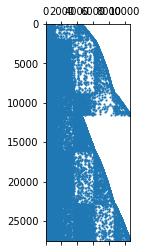

In [15]:
# Plot
import matplotlib.pylab as plt

plt.spy(utility_matrix, markersize=1)

In [45]:
A.todense()

matrix([[0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.    